# Fine-tune Llama-3-8B with Llama-3-405B synthetic data

<a target="_blank" href="https://colab.research.google.com/github/adamcohenhillel/LLMs-Cheatsheet/blob/main/fine-tune-llama3-8b-with-llama3-405b-data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

A simple notebook for fine-tuning a small model (Llama-3-8B) to be an  expert in a specific domain, by letting a larger, more capable model (Llama-3-405B) teach it (by generating synthetic dataset for that domain).

You can run this notebook on Google Colab (I use an L4 GPU).

Small models are really useful and important because you can run them on your own personal hardware at home, making it much more secure, private, and cheaper. Small(ish) models for the win!

This was loosely created by [@adamcohenhillel](https://x.com/adamcohenhillel). A HUGE shoutout to [@maximelabonne](https://twitter.com/maximelabonne) and his [LLM course repo](https://github.com/mlabonne/llm-course) on which this notebook is based on!


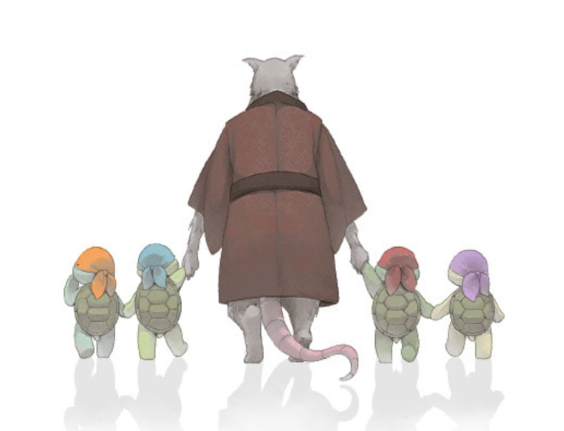

### Install Dependencies

In [9]:
!pip install -qqq -U transformers datasets accelerate peft trl bitsandbytes wandb openai pandas==2.0.3 huggingface_hub

### Setup variables

Add your API keys for the following providers (we use Together AI to inference Llama-3-405B, but you can also use AWS, OctoAI, Groq, etc.)

And change `topic` to whatever you want the larger model to teach the small model, or leave it as the default I used, "First-Aid medical Skills". You can also adjust `extra_instructions` if you want the larger model to generate the data in a curtain way, for example -> markdown.

Notes:
- For speed, we are only generating 50 examples for the dataset, but you can adjust it as you wish

In [10]:
import os
import openai
import pandas as pd
from typing import List, Dict
import json

# keys:
TOGETHER_API_KEY="<PLACEHOLDER>" # needed for inferencing Llama-3-405B
BASE_URL="https://api.together.xyz/v1" # needed for inferencing Llama-3-405B
WANDB_KEY = "<PLACEHOLDER>"
HUGGINGFACE_API_KEY = "<PLACEHOLDER>" # needed for fetching Llama-3-8B

# Dataset settings:
total_examples_count = 20          # how many examples to generate in total for the training set
examples_per_query = 20            # how many examples to generate per query to Llama3 405B (good to keep somewhat low, to maintain quality)
topic = "First-Aid medical Skills"          # the topic to generate examples for
extra_instructions = """
"""
dataset_file = "dataset.csv"

client = openai.OpenAI(
    # TOGETHER AI:
    api_key=TOGETHER_API_KEY,
    base_url="https://api.together.xyz/v1",
)


### Generating the Dataset
To create a domain-specific dataset, we'll harness the power of a large language model (Llama-3-405B) to generate a new dataset for training a smaller model in a specific domain (defined by the 'topic' variable). Traditionally, adapting LLMs to specific tasks involves two stages: Supervised Fine-Tuning (SFT) and Preference Alignment. However, we'll be using a novel fine-tuning technique called **ORPO** (Optimized Reinforcement Preference Optimization), which combines these stages into a single process. This approach significantly reduces computational resources and training time.

For more information on ORPO, you can refer to [Maxim's detailed blog post](https://mlabonne.github.io/blog/posts/2024-04-19_Fine_tune_Llama_3_with_ORPO.html#orpo)

----

Now, let's create a simple function that calls Llama-3-405B, with a system prompt asking to create data in a specific format (needed for the training), on our topic. (Note that we tell it it will be used to train a smaller model):

In [11]:
def generate_examples(previous_summary: str = "") -> List[Dict[str, str]]:
    prompt = f"""You are an expert in: {topic}.

Your goal is to generate a dataset of training examples in order to transfer your knowledge to a smaller model.

{extra_instructions}

Each training example is a JSON object with the following format:
[
    {{
        "source": "human",
        "chosen": "The chosen response",
        "rejected": "The rejected response",
        "prompt": "The user's prompt",
        "system": "The system message",
        "question": "A relevant question",
        "summary": "A brief summary of the example"
    }}
]

Return a list of {examples_per_query} training examples.

RETURN ONLY THE JSON, WITHOUT ANY OTHER TEXT OR FORMATTING.
YOU MUST RETURN A FULL AND VALID JSON ARRAY, WITH NO MISSING VALUES OR BRACKETS.
"""

    response = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo",
        # model="gpt-4",
        messages=[
            {"role": "system", "content": prompt}
        ],
    )

    # Parse the JSON response
    print(response.choices[0].message.content)
    print("-"*100)
    examples = json.loads(response.choices[0].message.content)
    return examples

Now we can `generate_examples` until we have the amount of training data we need (as specifiedi in a var above).

TODO: Give context about previously generated data, to reduce duplication

In [12]:

dataset = []
previous_summary = ""
while len(dataset) < total_examples_count:
    batch = generate_examples(previous_summary)
    dataset.extend(batch)
    previous_summary = json.dumps([example['summary'] for example in dataset[-5:]])
    print(f"Generated {len(dataset)} examples so far...")

# Save the dataset as JSON
with open("dataset.json", 'w') as f:
    json.dump(dataset, f, indent=2)

# Convert the dataset to a pandas DataFrame and save it to a CSV file
df = pd.DataFrame(dataset)
df.to_csv(dataset_file, index=False)

print("Dataset saved as:")
print("1. dataset.json")
print("2. dataset.csv")

AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API key provided. You can find your API key at https://api.together.xyz/settings/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

# Training, fune tuning Llama-3-8B with ORPO

Llama 3 8B is the smallest model in Meta's latest family of large language models (LLMs). Despite its compact size, it demonstrates impressive performance on general evaluations. Moreover, with further fine-tuning, this model can excel in specific knowledge domains.

For training, as mentioned above, we are going to use **ORPO**, which is a new fine-tuning technique that combines the traditional supervised fine-tuning and preference alignment stages into a single process. It is explained well [here](https://mlabonne.github.io/blog/posts/2024-04-19_Fine_tune_Llama_3_with_ORPO.html#orpo)

------

Let's import the necessary libraries and log in to W&B (optional):


In [8]:
import gc
import os

import torch
import wandb
from datasets import load_dataset
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from trl import ORPOConfig, ORPOTrainer, setup_chat_format

wandb.login(key=WANDB_KEY)

if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    attn_implementation = "flash_attention_2"
    torch_dtype = torch.bfloat16
else:
    attn_implementation = "eager"
    torch_dtype = torch.float16


ModuleNotFoundError: No module named 'distutils'

#### Load the Llama 3 8B model (4-bit precision) and set the LoRA configuration using PEFT for QLoRA.

Now we need to download the model from huggingface, load it to memory and set the training parameters
> You need to submit a request to access meta-llama/Meta-Llama-3-8B and be logged in to your Hugging Face account. Alternatively, you can load ungated copies of the model, like NousResearch/Meta–Llama-3-8B.

In [6]:
from huggingface_hub import login

login(token=HUGGINGFACE_API_KEY)

# Model
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"
new_model = f"{topic}-Llama-3-8B"

# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)
model, tokenizer = setup_chat_format(model, tokenizer)
model = prepare_model_for_kbit_training(model)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

#### Load the created dataset
Now we need to load the CSV dataset we created earlier to a dataset object. We are also using `setup_chat_format()` function to modify the model and tokenizer for ChatML support - which automatically applies this chat template, adds special tokens, and resizes the model’s embedding layer to match the new vocabulary size.

In [11]:
from datasets import load_dataset
import os

# Load the dataset from the CSV file
dataset = load_dataset('csv', data_files=dataset_file, split="train")

# Shuffle and select the number of rows based on the dataset size
dataset_size = len(dataset)
num_rows_to_select = min(100, dataset_size)
dataset = dataset.shuffle(seed=42).select(range(num_rows_to_select))

def format_chat_template(row):
    chosen_message = [{"role": "user", "content": row["chosen"]}]
    rejected_message = [{"role": "user", "content": row["rejected"]}]

    row["chosen"] = tokenizer.apply_chat_template(chosen_message, tokenize=False)
    row["rejected"] = tokenizer.apply_chat_template(rejected_message, tokenize=False)
    return row


dataset = dataset.map(
    format_chat_template,
    num_proc= os.cpu_count(),
)
dataset = dataset.train_test_split(test_size=0.01)


### Start train!

The speed here is obvs depending on the number of examples in the dataset, so if you just want to try it out, I'd recommend generating only 10-20 examples, and see that everything works as expected.

In [12]:
orpo_args = ORPOConfig(
    learning_rate=8e-6,
    beta=0.1,
    lr_scheduler_type="linear",
    max_length=1024,
    max_prompt_length=512,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    report_to="wandb",
    output_dir="./results/",
)

trainer = ORPOTrainer(
    model=model,
    args=orpo_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    tokenizer=tokenizer,
)
trainer.train()
trainer.save_model(new_model)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/orpo_trainer.py:247: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: adamcohenhillel (adamcohenhillel-privsovcom). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
1,8.507500,8.470244,0.722500,1.384000,1.384000,-0.867425,-0.841051,0.000000,-0.026374,-8.410508,-8.674246,-0.244328,-0.243362,8.386873,-0.833715,-0.263789
2,8.380500,8.444321,0.761600,1.313000,1.313000,-0.865323,-0.838492,0.000000,-0.026832,-8.384916,-8.653234,-0.251082,-0.249358,8.360690,-0.836309,-0.268372


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


#### Lastly, let’s merge the QLoRA adapter with the base model and push it to the Hugging Face Hub.


In [ ]:
# Flush memory
# del trainer, model
gc.collect()
torch.cuda.empty_cache()

# Reload tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
model, tokenizer = setup_chat_format(model, tokenizer)

# Merge adapter with base model
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()

model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]